# NetworkX: Graph-based analysis of genomes sharing identical 16S rRNA sequences

**Set Up**

In [57]:
from Bio import AlignIO
from Bio import SeqIO
import networkx as nx
from pathlib import Path
import hashlib
from collections import defaultdict
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import dwave_networkx as dnx
import seaborn as sns
import matplotlib.pyplot as plt

**Getting the initial graph**

Step 1: Assign genome as a node

In [58]:
records = AlignIO.read("../supplementary_file_18/output/16S_extracted_from_genomes_trimmed_aln.fasta", "fasta")

In [59]:
genomes = list(set([_.name for _ in records]))

Step 2: Create a complete graph

In [60]:
graph = nx.complete_graph(genomes)

Step 3: Assign 16S seq (hashes) as an attribute. 

To do this, I first need to get a dictionary with genomes accessions (nodes) as a key, and the list of all 16S rRNA/hahses as a value. 

Then we can assign these as attributes

In [61]:
hashes_all = defaultdict(list)

for _ in records:
    hashes_all[_.name].append(hashlib.md5(str(_.seq).encode('utf-8')).hexdigest())
    
hashes = {k:list(set(v)) for k, v in hashes_all.items()}

In [62]:
nx.set_node_attributes(graph, hashes, "hashes")

Step 4: Assign edges weights (number of shared identical 16S rRNA sequences for a given edge)

In [63]:
def get_number_of_shared_16S(list1, list2):
    """Retrun number of shared items between
    two lists. 
    
    :param 1: list of items in group 1
    :param 2: list of items in group 2
    """
    
    shared_items = len(list(set(list1).intersection(list2)))
    return shared_items

In [64]:
for edge in graph.edges:
    n1, n2 = edge
    graph[n1][n2]["weight"] = get_number_of_shared_16S(graph.nodes[n1]['hashes'], graph.nodes[n2]['hashes'])

Step 5: Remove edges between given pair of genomes, if they do not share a single 16S rRNA sequence

In [65]:
edges_to_remove = [(n1,n2) for n1, n2, attrs in graph.edges(data=True) if attrs["weight"] == 0]
graph.remove_edges_from(edges_to_remove)

Step 6: Remove "list" attributes

In [66]:
for node in graph:
    del graph.nodes[node]['hashes']

Step 7: Save the graph as graphml

In [67]:
nx.write_graphml_lxml(graph, Path("genome_16S_network.graphml"))

**Correcting the position of the nodes**

After the position of the nodes are fixed using Cytoscape, we can now parse the file
and polish the final graph. 

Step 1: Get the position of the nodes

In [68]:
import xml.dom.minidom
file=('genome_16S_network.xml')
positions ={}
xmldoc=xml.dom.minidom.parse(file)
STNode = xmldoc.getElementsByTagName('node')
for STChild in STNode:
    ST = STChild.attributes['label'].value
    for parts in STChild.childNodes:
        if parts.nodeType == xml.dom.Node.ELEMENT_NODE: 
            if parts.tagName =='graphics':
                x = float(parts.attributes['x'].value)
                y = float(parts.attributes['y'].value)
                positions[str(ST)] = list((x,y))
                import xml.dom.minidom


Step 2: Get the position of the edges

In [69]:
edges =[]
xmldoc=xml.dom.minidom.parse(file)
edgesNode = xmldoc.getElementsByTagName('edge')
for _ in edgesNode:
    source = str(_.attributes['label'].value).split(' (-) ')
    edges.append([source[0], source[1]])


Step 3: Create new graph

In [70]:
G = nx.Graph()
pos = nx.spring_layout(G)
for k, v in positions.items():
    G.add_node(k)
    pos[k] = v

In [71]:
nx.set_node_attributes(G, positions, "pos")

In [72]:
for _ in edges:
    G.add_edge(_[0], _[1])

In [73]:
nx.set_node_attributes(G, hashes, "hashes")

In [74]:
for edge in G.edges:
    n1, n2 = edge
    G[n1][n2]["weight"] = get_number_of_shared_16S(G.nodes[n1]['hashes'], G.nodes[n2]['hashes'])

Checking if the graph worked

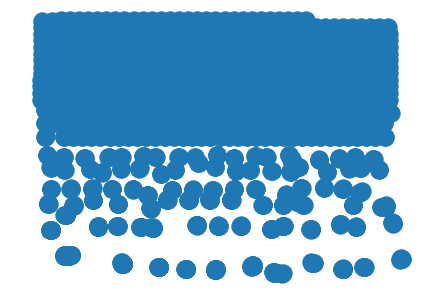

In [75]:
pos = nx.spring_layout(graph,pos=positions)
nx.draw(graph, pos=pos)

**Get annotations for hoover text**

NOTE: Save this information as csv table for future analyses. 

Things that we want to include are:
- Genome accession
- Assigned species names
- Assigned strain names
- Degree/Node connections
- Total number of 16S copies
- Total number of unique 16S copies

In [76]:
df = pd.DataFrame([_ for _ in G.nodes], columns =['accession'])

In [77]:
datadir = Path("../../MLST_paper_repository/data/raw_data/RefSeq/")
filenames = sorted(datadir.glob("strep*/GCF*/*report.txt"))

In [78]:
organism_name = {}
strain_name = {}
for fname in filenames:
    accession = '_'.join(str(fname).split('/')[-1].split('_')[:2])
    with open(fname) as f:
        lines = f.readlines()
        organism = ' '.join([_ for _ in lines if 'Organism name' in _][0].strip('# Organism name:  ').replace(" (high GC Gram+)", "").replace('\n', '').split(' ')[:2])
        strain = ''.join([_ for _ in lines if 'Infraspecific name' in _]).strip('# Infraspecific name:  strain=').replace('\n', '')
        organism_name[accession] = organism
        strain_name[accession] = strain
df['organism_name'] = df['accession'].map(organism_name).fillna('NA')
df['strain_name'] = df['accession'].map(strain_name).fillna('NA')

In [79]:
df['16S_copies'] = df['accession'].map({k:len(v) for k, v in hashes_all.items()}).fillna('NA')

In [80]:
df['unique_16S_copies'] = df['accession'].map({k:len(v) for k, v in hashes.items()}).fillna('NA')

**Visualisation of the graph using plotly**

In [81]:
edge_x = []
edge_y = []
edge_weight = []
for edge in G.edges():
    for k, v in positions.items():
        if str(edge[0]) == str(k):
            edge_x.append(v[0])
            edge_y.append(v[1])
            edge_weight.append(str(G[edge[0]][edge[1]]['weight']))
        if str(edge[1]) == str(k):
            edge_x.append(v[0])
            edge_y.append(v[1])
            edge_x.append(None)
            edge_y.append(None)


In [82]:
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

In [83]:
node_x = []
node_y = []
for node in G.nodes():
    for k, v in positions.items():
        if str(node) == str(k):
            node_x.append(v[0])
            node_y.append(v[1])

In [84]:
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=5,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=1))


Get degree/node connections for each node. 
NOTE: append this information to the df

In [85]:
degree = {}
for node, adjacencies in enumerate(graph.adjacency()):
    degree[str(adjacencies[0])] = len(adjacencies[1])
df['degree'] = df['accession'].map(degree)
df.to_csv('genome_16S_info.csv', index=False)


Get hoover text for each node/genome

In [86]:
annotations = {_:'<b>Accession: </b>'+_+
               '<br><b>Species name: </b>'+organism_name[_]+
               '<br><b>Strain: </b>'+strain_name[_]+
               '<br><b>Degree: </b>'+str(degree[_])+
               '<br><b>Total 16S copies: </b>'+str(len(hashes_all[_]))+
               '<br><b>Unique 16S copies: </b>'+str(len(hashes[_]))
               for _ in G.nodes}

node_trace['text'] = [annotations[_] for _ in G.nodes]

Get hoover text for each edge

In [87]:
middle_node_x = []
middle_node_y = []
weights = []
for edges in G.edges():
    edge1_x = G.nodes[edges[0]]['pos'][0]
    edge1_y = G.nodes[edges[0]]['pos'][1]
    edge2_x = G.nodes[edges[1]]['pos'][0]
    edge2_y = G.nodes[edges[1]]['pos'][1]
    new_x_pos = (edge1_x + edge2_x)/2
    new_y_pos = (edge1_y + edge2_y)/2
    middle_node_x.append(new_x_pos)
    middle_node_y.append(new_y_pos)


for edges in G.edges():
    weights.append("<b>Number of 16S shared: </b>"+str(G[edges[0]][edges[1]]['weight'])+
                  '<br><b>Shared 16S: </b>'+' '.join(list(set(hashes[edges[0]]).intersection(hashes[edges[1]]))))
            
middle_node_trace = go.Scatter(
    x=middle_node_x, y=middle_node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=False,
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=5,
        opacity=0,
        line_width=1))
middle_node_trace['text'] = weights

In [88]:
node_adjacencies = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))

node_trace.marker.color = node_adjacencies

In [90]:
fig = go.Figure(data=[edge_trace, node_trace] +[ middle_node_trace],
             layout=go.Layout(
                title='',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                hoverlabel=dict(font_size=10),

                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

fig.show()
fig.update_layout(
    plot_bgcolor='white')
fig.write_html("../supplementary_file_21.html")

fig.write_image("genome_16S_00001.pdf")

In [91]:
components= [len(_) for _ in list(nx.connected_components(G))]

In [92]:
from collections import Counter
print(Counter(sorted(components)))

Counter({1: 527, 2: 84, 3: 41, 4: 16, 6: 10, 5: 6, 10: 4, 8: 3, 9: 3, 7: 2, 15: 2, 18: 2, 20: 2, 12: 1, 14: 1, 17: 1, 23: 1, 27: 1, 45: 1, 47: 1})


Colour the graph based on whether the graphs is clique or not.

In [93]:
clique = {}
components = [_ for _ in list(nx.connected_components(G))]
for component in components:
    if dnx.is_clique(G, component) == True:
        for genome in component:
            clique[genome] = "rgb(59,82,139)"
    if dnx.is_clique(G, component) == False:
        for genome in component:
            clique[genome] = "rgb(94,201,98)"

In [94]:
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=False,
        colorscale='YlGnBu',
        reversescale=False,
        color=[],
        size=5,
        line_width=1))

In [95]:
node_colours = [clique[_] for _ in G.nodes]
node_trace.marker.color = node_colours
node_trace['text'] = [annotations[_] for _ in G.nodes]

In [96]:
fig = go.Figure(data=[edge_trace, node_trace] + [ middle_node_trace],
             layout=go.Layout(
#                 title='<br><b>Unique species according to pyANI analysis within each connected component</b>',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                hoverlabel=dict(font_size=10),

                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

fig.show()
fig.update_layout(
    plot_bgcolor='white')
fig.write_html("../supplementary_file_22.html")

fig.write_image("genome_16S_00002.pdf")

In [52]:
fixed_colours = defaultdict(list)
for nodes in enumerate(nx.connected_components(G)):
    x = {_:organism_name[_] for _ in nodes[1] if organism_name[_] != 'Streptomyces sp.'}
    if len(list(set(x.values()))) != 0:
        colour_per_species = {}
        palette = sns.color_palette("Spectral", len(list(set(x.values()))))
        palette=palette.as_hex()
        colour_per_species.update(dict(zip(list(set(x.values())),palette)))
        for k, v in x.items():
            fixed_colours[k] = colour_per_species[v]


In [53]:
for node in G.nodes:
    if node not in fixed_colours.keys():
        fixed_colours[node] = '#808080'

In [54]:
node_colours = [fixed_colours[_] for _ in G.nodes]
node_trace.marker.color = node_colours
node_trace['text'] = [annotations[_] for _ in G.nodes]

In [56]:
fig = go.Figure(data=[edge_trace, node_trace] + [ middle_node_trace],
             layout=go.Layout(
#                 title='<br><b>Unique species according to pyANI analysis within each connected component</b>',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                hoverlabel=dict(font_size=10),

                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

fig.show()
fig.update_layout(
    plot_bgcolor='white')
fig.write_html("genome_16S_00003.html")

fig.write_image("genome_16S_00003.pdf")